## Median Line Method

In [ ]:
def median_line(points):

    # Calculate the covariance matrix of the points
    covariance_matrix = np.cov(np.array(points).T)

    # Extract the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # The eigenvector corresponding to the largest eigenvalue is the direction vector of the median line
    direction_vector = eigenvectors[:, np.argmax(eigenvalues)]

    # Calculate the median point of the points
    median_point = np.median(points, axis=0)

    return direction_vector, median_point

In [3]:
import csv
import numpy as np
from scipy.optimize import minimize

# Function to load house coordinates from a CSV file
def load_house_coordinates(file_path):
    houses = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header if exists
        for row in reader:
            houses.append((float(row[0]), float(row[1])))  # Assuming latitude is in column 0 and longitude in column 1
    return houses

# Function to calculate the distance from a point to a line
def distance_to_line(point, line_direction, line_point):
    identity = np.identity(2)
    point_vector = np.array(point)
    line_direction_vector = np.array(line_direction)
    line_point_vector = np.array(line_point)

    projection_matrix = identity - np.outer(line_direction_vector, line_direction_vector)
    distance = np.linalg.norm(np.dot(projection_matrix, point_vector - line_point_vector))

    return distance

# Objective function for optimization
def objective_function(line_params, *args):
    houses = args[0]
    direction = line_params[:2]
    point = line_params[2:]

    total_distance = 0
    for house in houses:
        total_distance += distance_to_line(house, direction, point)

    return total_distance

# Main function
def main():
    # Load data
    houses = load_house_coordinates("housing.csv")

    # Initial guess for line parameters (direction vector and point on line)
    initial_params = np.zeros(4)
    initial_params[:2], initial_params[2:] = median_line(houses)

    # Perform optimization using Gradient Descent
    result = minimize(objective_function, initial_params, args=(houses,), method='CG')

    # Extract optimized line parameters
    final_direction = result.x[:2]
    final_point = result.x[2:]

    # Output
    print("Direction Vector:", final_direction)
    print("Point on Line:", final_point)

if __name__ == "__main__":
    main()


Direction Vector: [ 0.70710671 -0.70710686]
Point on Line: [-118.46475643   34.28475646]


## Ransac

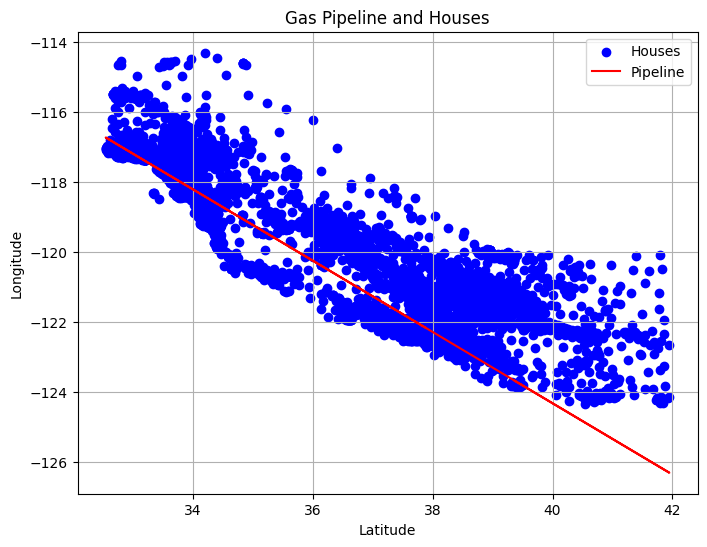

Direction Vector: [1, -1.0168513105680146 ]
Point on Line: [ 37.88 , [-122.16020857] ]


In [ ]:
import csv
import numpy as np
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt

# Function to load house coordinates from a CSV file
def load_house_coordinates(file_path):
    houses = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header if exists
        for row in reader:
            houses.append((float(row[0]), float(row[1])))  # Assuming latitude is in column 0 and longitude in column 1
    return houses

# Main function
def main():
    # Load house coordinates from CSV
    file_path = "housing.csv"
    houses = load_house_coordinates(file_path)

    # Convert house coordinates to numpy array
    house_coords = np.array(houses)

    # Fit a line using RANSAC
    ransac = RANSACRegressor()
    ransac.fit(house_coords[:, 1].reshape(-1, 1), house_coords[:, 0])

    # Extract optimized line parameters
    slope = ransac.estimator_.coef_
    intercept = ransac.estimator_.intercept_

    # Plot houses and line
    plt.figure(figsize=(8, 6))
    plt.scatter(house_coords[:, 1], house_coords[:, 0], color='blue', label='Houses')
    plt.plot(house_coords[:, 1], slope * house_coords[:, 1] + intercept, color='red', label='Pipeline')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Gas Pipeline and Houses')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Output direction vector and point on the line
    print("Direction Vector: [1,", slope[0], "]")
    print("Point on Line: [", house_coords[0, 1], ",", slope * house_coords[0, 1] + intercept, "]")

if __name__ == "__main__":
    main()


## Gradient Descent

In [ ]:
import csv
import numpy as np

# Function to load house coordinates from a CSV file
def load_house_coordinates(file_path):
    houses = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header if exists
        for row in reader:
            houses.append((float(row[0]), float(row[1])))  # Assuming latitude is in column 0 and longitude in column 1
    return houses

# Objective function to calculate total distance
def objective_function(line_params, houses):
    direction = line_params[:2]
    point = line_params[2:]

    total_distance = 0
    for house in houses:
        total_distance += distance_to_line(house, direction, point)

    return total_distance

# Gradient Descent algorithm
def gradient_descent(houses, initial_line_params, learning_rate=0.01, max_iter=1000, tolerance=1e-5):
    line_params = initial_line_params
    prev_cost = float('inf')

    for i in range(max_iter):
        cost = objective_function(line_params, houses)
        if abs(prev_cost - cost) < tolerance:
            break

        gradient = calculate_gradient(line_params, houses)
        line_params -= learning_rate * gradient
        prev_cost = cost

    return line_params

# Calculate gradient of the objective function
def calculate_gradient(line_params, houses, epsilon=1e-6):
    gradient = np.zeros_like(line_params)

    for i in range(len(line_params)):
        delta = np.zeros_like(line_params)
        delta[i] = epsilon
        gradient[i] = (objective_function(line_params + delta, houses) -
                       objective_function(line_params - delta, houses)) / (2 * epsilon)

    return gradient

# Function to calculate the distance from a point to a line
def distance_to_line(point, line_direction, line_point):
    identity = np.identity(2)
    point_vector = np.array(point)
    line_direction_vector = np.array(line_direction)
    line_point_vector = np.array(line_point)

    projection_matrix = identity - np.outer(line_direction_vector, line_direction_vector)
    distance = np.linalg.norm(np.dot(projection_matrix, point_vector - line_point_vector))

    return distance

# Main function
def main():
    # Load house coordinates from CSV
    file_path = "hong.csv"
    houses = load_house_coordinates(file_path)

    # Initialize parameters of the line (direction vector and a point on the line)
    initial_line_params = np.random.rand(4)  # Random initialization

    # Run Gradient Descent to find an efficient line
    efficient_line_params = gradient_descent(houses, initial_line_params)

    # Output results
    direction_vector = efficient_line_params[:2]
    point_on_line = efficient_line_params[2:]
    print("Direction Vector:", direction_vector)
    print("Point on Line:", point_on_line)

if __name__ == "__main__":
    main()


Direction Vector: [ 7.92633534e+21 -8.28662331e+21]
Point on Line: [ 3.45312980e+10 -2.55722205e+10]
